In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from scipy.stats import entropy

In [2]:
import time
start_time1 = time.time()
data = pd.read_excel(r'..\..\dataArticle\publicData\data.xlsx')
data.columns
data

Index(['Person', 'State', 'x', 'y', 'z'], dtype='object')

,Person,State,x,y,z
0,33.0,Jogging,-0.694638,12.680544,0.503953
1,33.0,Jogging,5.012288,11.264028,0.953424
2,33.0,Jogging,4.903325,10.882658,-0.081722
3,33.0,Jogging,-0.612916,18.496431,3.023717
4,33.0,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...,...
1048570,7.0,Standing,-8.080000,5.090000,-0.690000
1048571,7.0,Standing,-8.120000,5.520000,-0.800000
1048572,7.0,Standing,-7.890000,5.790000,-0.720000
1048573,7.0,Standing,-7.890000,5.980000,-0.270000


In [3]:
G = 9.80665
data['x'] = data['x'].div(G)
data['y'] = data['y'].div(G)
data['z'] = data['z'].div(G)
data

,Person,State,x,y,z
0,33.0,Jogging,-0.070833,1.293056,0.051389
1,33.0,Jogging,0.511111,1.148611,0.097222
2,33.0,Jogging,0.500000,1.109722,-0.008333
3,33.0,Jogging,-0.062500,1.886111,0.308333
4,33.0,Jogging,-0.120833,1.234722,0.734722
...,...,...,...,...,...
1048570,7.0,Standing,-0.823931,0.519036,-0.070360
1048571,7.0,Standing,-0.828010,0.562883,-0.081577
1048572,7.0,Standing,-0.804556,0.590416,-0.073420
1048573,7.0,Standing,-0.804556,0.609790,-0.027532


In [4]:
data = data.drop(columns = 'Person')
df = data.groupby(['State'])
df.first()

,x,y,z
State,,,
Downstairs,-0.004167,0.508333,0.663889
Jogging,-0.070833,1.293056,0.051389
Sitting,0.265126,0.985046,0.105556
Standing,-0.191707,1.004420,-0.023611
Upstairs,1.031945,0.441667,-0.386111
Walking,0.086111,0.816667,0.284722


In [5]:
Downstairs = df.get_group(('Downstairs'))
Jogging = df.get_group(('Jogging'))
Sitting = df.get_group(('Sitting'))
Standing = df.get_group(('Standing'))
Upstairs = df.get_group(('Upstairs'))
Walking = df.get_group(('Walking'))

len(Downstairs)
len(Jogging)
len(Sitting)
len(Standing)
len(Upstairs)
len(Walking)

97813

325975

54876

44541

118589

406776

In [6]:
stand = Standing
len(stand)
sit = Sitting
len(sit)
jog = Jogging
len(jog)
walk = Downstairs.append(Upstairs).append(Walking)
len(walk)

44541

54876

325975

623178

In [7]:
#Check nan value & remove 
len(walk.index)

walk = walk.dropna()
walk.index = pd.RangeIndex(len(walk.index))
len(walk.index)
walk.isnull().sum().sum()

type(walk)

623178

623177

0

pandas.core.frame.DataFrame

In [8]:
#Fs = 20Hz
frame = 200
stride = 100

def numberOfFrame(dataAction):
    return [dataAction[i:i+frame] for i in range(0,len(dataAction),stride) 
                    if i+frame<=len(dataAction)]

X_stand = numberOfFrame(stand)
X_sit = numberOfFrame(sit)
X_jog = numberOfFrame(jog)
X_walk = numberOfFrame(walk)

print ('X_stand: ', len(X_stand))
print ('X_sit: ', len(X_sit))
print ('X_jog: ', len(X_jog))
print ('X_walk: ', len(X_walk))

X_stand:  444
X_sit:  547
X_jog:  3258
X_walk:  6230


In [9]:
from sklearn.model_selection import train_test_split 
RateTrain = 0.4

X_stand_train, X_stand_test = train_test_split(X_stand, test_size = RateTrain)
X_sit_train, X_sit_test = train_test_split(X_sit, test_size = RateTrain)
X_jog_train, X_jog_test = train_test_split(X_jog, test_size = RateTrain)
X_walk_train, X_walk_test = train_test_split(X_walk, test_size = RateTrain)

print('train =  ', len(X_stand_train)+ len(X_sit_train) + len(X_jog_train) + len(X_walk_train))
print('test =  ', len(X_stand_test)+ len(X_sit_test) + len(X_jog_test) + len(X_walk_test))

train =   6286
test =   4193


In [10]:
# Don't know how many variables when creating function => use splat operator.
def mergeArrayAction (*dataActions):
    data = {
        "data": [],
        "label": []
    }
    index = 0
    for dataAction in dataActions: 
        for act in dataAction: 
            data["data"].append(np.array(acts))
            data["label"].append(index)
        index += 1
    return data

dataTrain = mergeArrayAction(
    X_stand_train,
    X_sit_train,
    X_jog_train,
    X_walk_train, 
)

dataTest = mergeArrayAction(
    X_stand_test,
    X_sit_test,
    X_jog_test,
    X_walk_test
)

train_data = dataTrain["data"]
train_label = dataTrain["label"]

test_data = dataTest["data"]
test_label = dataTest["label"]

print('train-data length: ', len(train_data))
print('train-label length: ', len(train_label))
print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  6286
train-label length:  6286
test-data length:  4193
test-label length:  4193


In [11]:
def featuresFromBuffer(at):
    feat = np.zeros(15)   
    
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means 
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms

    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std

    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[9:12] = med
    
    # Range
    Range = [np.amax(i)-np.amin(i) for i in [x, y, z]]    
    feat[12:15] = Range
    
    return feat  

In [12]:
#Create feature array
train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)

6286

4193

In [13]:
#Handel nan value
np.where(np.isnan(train_features)) 
train_features = np.nan_to_num(train_features)
np.where(np.isnan(test_features))
test_features = np.nan_to_num(test_features)      

len(train_features)
len(train_label)

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

6286

6286

In [14]:
#Classifier 
from sklearn.feature_selection import SelectFromModel
print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
#format: pass score in {:.3f}
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))

print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree 
clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)
print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\n Random Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)
print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\nKNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))


Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 0.993
Accuracy of GBDT classifier on test set: 0.982


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.979
Accuracy of Decision Tree classifier on test set: 0.969


SVM:
Accuracy on training set: 0.99
Accuracy on test set: 0.98


 Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.990


KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.98


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
      
y_pred = clf4.predict(test_features)

print('micro')
f1_score(test_label, y_pred, average='micro')
recall_score(test_label, y_pred, average='micro')
precision_score(test_label, y_pred, average='micro',labels=np.unique(y_pred))

#overall measurement
print('macro')
f1_score(test_label, y_pred, average='macro')
recall_score(test_label, y_pred, average='macro')
precision_score(test_label, y_pred, average='macro',labels=np.unique(y_pred))

micro


0.9895063200572383

0.9895063200572383

0.9895063200572383

macro


0.9877506361218428

0.984672294873865

0.9910074047262337

Confusion matrix, without normalization
[[ 177    0    0    1]
 [   2  211    1    5]
 [   0    0 1290   14]
 [   0    0   21 2471]]
Normalized confusion matrix
[[0.99 0.   0.   0.01]
 [0.01 0.96 0.   0.02]
 [0.   0.   0.99 0.01]
 [0.   0.   0.01 0.99]]


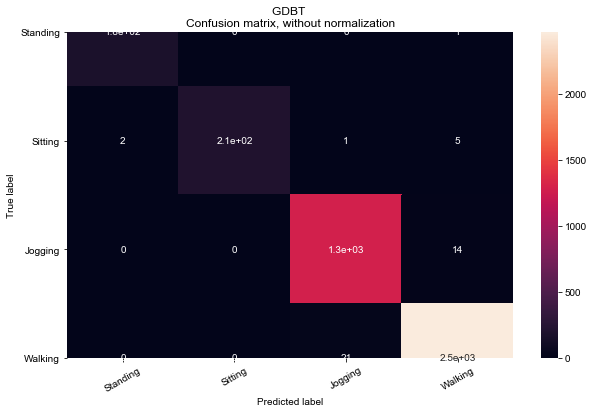

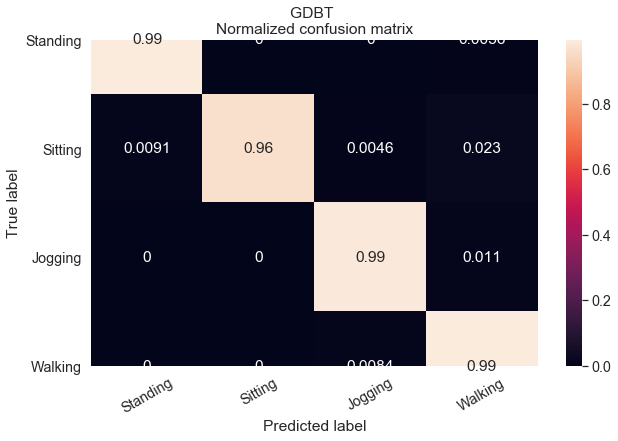


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       1.00      0.96      0.98       219
           2       0.98      0.99      0.99      1304
           3       0.99      0.99      0.99      2492

    accuracy                           0.99      4193
   macro avg       0.99      0.98      0.99      4193
weighted avg       0.99      0.99      0.99      4193



In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
from sklearn.utils.multiclass import unique_labels

target_names = ['Standing', 'Sitting', 'Jogging', 'Walking']

y_pred = clf4.predict(test_features)
lables = np.concatenate([target_names, ])

from sklearn.metrics import f1_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, title=None):
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize = (10,6))
    dataFrame = pd.DataFrame(cm)
    sb.heatmap(dataFrame, annot = True)  
    ax.set(xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    sb.set(font_scale = 1.3)

np.set_printoptions(precision=2)

plot_confusion_matrix(test_label, y_pred, classes=lables,  
        title='GDBT \nConfusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_label, y_pred, classes=lables, normalize=True,
        title='GDBT \nNormalized confusion matrix')

plt.show()
print ("\nClassification Report: ")
print (classification_report(test_label, y_pred,labels=np.unique(y_pred)))
